In [115]:
import os
import pandas as pd
import numpy as np

In [116]:
# Define the current directory
current_directory = os.getcwd()
current_directory = current_directory + "\\data"

In [117]:
def rendering_type(row):
    if row['Maxforce'] != 0 and row['Rendering'] != 0:
        return 'Stiffness'
    elif row['Maxforce'] == 0 and row['Rendering'] == 0:
        return 'Impedence, Stiffness'
    else:
        return 'Impedence'

In [118]:
# Function to normalize 'Feedback' between 0 and 1
def normalize_feedback(df):
    feedback_min = df['Feedback'].min()
    feedback_max = df['Feedback'].max()
    if feedback_max != feedback_min:  # Avoid division by zero
        df['Feedback'] = (df['Feedback'] - feedback_min) / (feedback_max - feedback_min)
    else:
        df['Feedback'] = 0  # If all values are the same, set to 0
    return df


In [119]:
def combine_and_split_by_rendering_type_modified(directory):
    # List all CSV files in the directory
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    print(csv_files)
    
    # Initialize empty dataframes for 'Stiffness' and 'Impedence'
    stiffness_df = pd.DataFrame()
    impedence_df = pd.DataFrame()
    dataframes = []  # To store individual dataframes for later use in normalization
    
    for file in csv_files:
        
        # Load each CSV file into a DataFrame
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        
        # Add the 'using' column based on the file name
        if any(x in file for x in ['F1', 'F2', 'M2']):
            df['using'] = 0
        else:
            df['using'] = 1
        
        # Extract participant ID from the file name (e.g., 'F1', 'F2', etc.)
        participant_id = file.split('_')[0]
        df['participant_id'] = participant_id  # Add participant ID to the dataframe
        
        # Store the dataframe in the list for later concatenation
        dataframes.append(df)
        
        # Check if 'Maxforce' and 'Rendering' columns exist in the CSV before processing
        if 'Maxforce' in df.columns and 'Rendering' in df.columns:
            # Add 'Rendering Type' column based on the provided logic
            df['Rendering Type'] = df.apply(rendering_type, axis=1)
        
        # Drop specified columns if they exist
        columns_to_drop = ['Achieved Temperature', 'Time Interval (s)', 'Time to Reach (s)']
        df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
        
        # Convert 'Time Stamp' to datetime if it's not already
        df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])
        
        # Add new 'Time Interval' column based on time difference between consecutive 'Time Stamp' values
        df['Time Interval'] = df['Time Stamp'].diff().dt.total_seconds().fillna(0)
        
        # Append rows to 'Stiffness' or 'Impedence' dataframe based on 'Rendering Type'
        if df['Rendering Type'].str.contains('Stiffness').any():
            stiffness_df = pd.concat([stiffness_df, df[df['Rendering Type'].str.contains('Stiffness')]], ignore_index=True)
        
        if df['Rendering Type'].str.contains('Impedence').any():
            impedence_df = pd.concat([impedence_df, df[df['Rendering Type'].str.contains('Impedence')]], ignore_index=True)

    # Combine all the individual dataframes into one for geometric normalization
    combined_data = pd.concat(dataframes)

    # Ensure there are no negative or zero values before applying log (for geometric mean calculation)
    combined_data['Feedback'] = combined_data['Feedback'].replace(0, np.nan)  # Replace zeros with NaN to avoid log(0) error
    combined_data.dropna(subset=['Feedback'], inplace=True)  # Drop rows where feedback is NaN

    # Calculate the global geometric mean (Mg) of the 'Feedback' column
    Mg = np.exp(np.mean(np.log(combined_data['Feedback'])))

    # Calculate the geometric mean (Mi) for each participant
    Mi = combined_data.groupby('participant_id')['Feedback'].apply(lambda x: np.exp(np.mean(np.log(x))))

    # Normalize 'Feedback' for each participant using the global (Mg) and participant-specific (Mi) geometric means
    combined_data['normalized_feedback'] = combined_data.apply(lambda row: row['Feedback'] / (Mi[row['participant_id']] / Mg), axis=1)

    # Split the normalized data back into 'stiffness_df' and 'impedence_df'
    stiffness_df = combined_data[combined_data['Rendering Type'] == 'Stiffness']
    impedence_df = combined_data[combined_data['Rendering Type'] == 'Impedence']

    # Return dataframes split by both 'Rendering Type' and 'using'
    using_0 = pd.concat([impedence_df[impedence_df['using'] == 0], stiffness_df[stiffness_df['using'] == 0]], ignore_index=True)
    using_1 = pd.concat([impedence_df[impedence_df['using'] == 1], stiffness_df[stiffness_df['using'] == 1]], ignore_index=True)

    return stiffness_df, impedence_df, using_0, using_1

In [120]:
stiffness_df, impedence_df, using_0, using_1 = combine_and_split_by_rendering_type_modified(current_directory)

['F1_2.csv', 'F1_3.csv', 'F2_2.csv', 'F2_3.csv', 'F3_2.csv', 'F3_3.csv', 'M1_2.csv', 'M1_3.csv', 'M2_2.csv', 'M2_3.csv', 'M3_2.csv', 'M3_3.csv', 'M4_2.csv', 'M4_3.csv', 'M5_2.csv', 'M5_3.csv']


In [121]:
# Display the shapes of the resulting DataFrames (optional)
print(f"Stiffness DataFrame shape: {stiffness_df.shape}")
print(f"Impedence DataFrame shape: {impedence_df.shape}")
print(f"Using=0 DataFrame shape: {using_0.shape}")
print(f"Using=1 DataFrame shape: {using_1.shape}")

Stiffness DataFrame shape: (192, 13)
Impedence DataFrame shape: (192, 13)
Using=0 DataFrame shape: (144, 13)
Using=1 DataFrame shape: (240, 13)


In [122]:
stiffness_df

,Name,Setpoint,Achieved Temperature,Time Interval (s),Time to Reach (s),Feedback,Time Stamp,Maxforce,Rendering,using,participant_id,Rendering Type,normalized_feedback
2,F1_2,32.0,31.28,9,9.76,65.0,2024-10-10 15:16:25,0.3,3.0,0,F1,Stiffness,12.597466
4,F1_2,24.0,26.88,9,9.74,65.0,2024-10-10 15:17:11,0.1,2.0,0,F1,Stiffness,12.597466
5,F1_2,40.0,39.10,9,9.93,68.0,2024-10-10 15:17:31,1.0,5.0,0,F1,Stiffness,13.178888
6,F1_2,24.0,32.75,9,9.87,72.0,2024-10-10 15:17:53,0.3,3.0,0,F1,Stiffness,13.954116
7,F1_2,32.0,28.35,9,9.85,68.0,2024-10-10 15:18:22,1.0,5.0,0,F1,Stiffness,13.178888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,M5_4,24.0,30.30,9,9.54,20.0,2024-10-14 22:01:47,0.1,2.0,1,M5,Stiffness,6.078536
19,M5_4,32.0,31.28,9,9.24,45.0,2024-10-14 22:02:49,0.3,3.0,1,M5,Stiffness,13.676706
21,M5_4,32.0,24.44,9,9.86,70.0,2024-10-14 22:03:28,0.5,4.0,1,M5,Stiffness,21.274877
24,M5_4,40.0,40.57,9,9.18,80.0,2024-10-14 22:04:30,1.0,5.0,1,M5,Stiffness,24.314145


### **🧷 렌더링 별 데이터 분석 (Impedence / Stiffness)**

<Figure size 800x600 with 0 Axes>

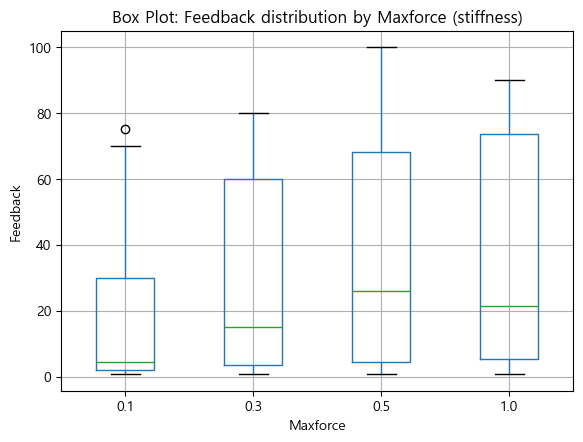

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (assuming it's in a CSV file)
# df = pd.read_csv('your_data.csv') # Uncomment this line to load your actual data

# Box Plot
plt.figure(figsize=(8, 6))
stiffness_df.boxplot(column='Feedback', by='Maxforce', grid=False)
plt.title('Box Plot: Feedback distribution by Maxforce (stiffness)')
plt.suptitle('')  # Suppress the default title
plt.xlabel('Maxforce')
plt.ylabel('Feedback')
plt.grid(True)
plt.show()


In [124]:
# Calculate the average Feedback for each Maxforce
avg_feedback_by_maxforce = stiffness_df.groupby('Maxforce')['Feedback'].mean()
print(avg_feedback_by_maxforce)

Maxforce
0.1    18.404167
0.3    28.802083
0.5    36.479167
1.0    38.466667
Name: Feedback, dtype: float64


<Figure size 800x600 with 0 Axes>

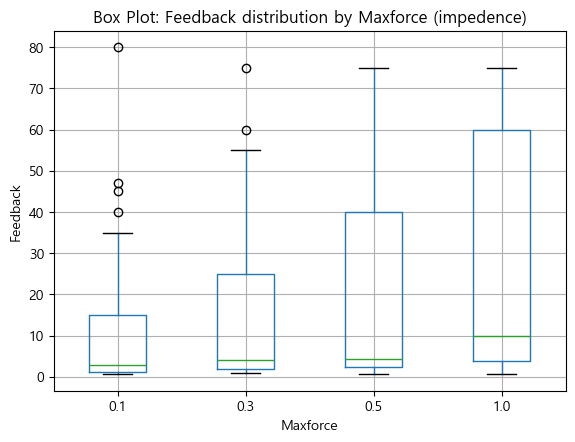

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (assuming it's in a CSV file)
# df = pd.read_csv('your_data.csv') # Uncomment this line to load your actual data

# Box Plot
plt.figure(figsize=(8, 6))
impedence_df.boxplot(column='Feedback', by='Maxforce', grid=False)
plt.title('Box Plot: Feedback distribution by Maxforce (impedence)')
plt.suptitle('')  # Suppress the default title
plt.xlabel('Maxforce')
plt.ylabel('Feedback')
plt.grid(True)
plt.show()


In [126]:
# Calculate the average Feedback for each Maxforce
avg_feedback_by_maxforce = impedence_df.groupby('Maxforce')['Feedback'].mean()
print(avg_feedback_by_maxforce)

Maxforce
0.1    11.789583
0.3    15.035417
0.5    21.786458
1.0    28.070833
Name: Feedback, dtype: float64


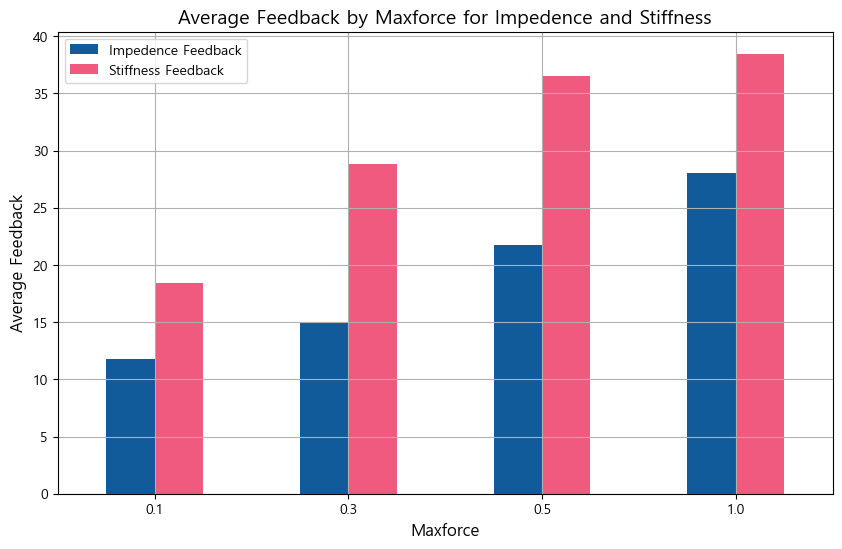

In [127]:
# Assuming 'impedence_df' and 'stiffness_df' are already defined
# Calculate the average Feedback for each Maxforce for both 'impedence_df' and 'stiffness_df'
avg_feedback_impedence = impedence_df.groupby('Maxforce')['Feedback'].mean()
avg_feedback_stiffness = stiffness_df.groupby('Maxforce')['Feedback'].mean()

# Combine both averages into a single DataFrame for comparison
avg_feedback_combined = pd.DataFrame({
    'Impedence Feedback': avg_feedback_impedence,
    'Stiffness Feedback': avg_feedback_stiffness
})

# Create the bar plot with custom colors
avg_feedback_combined.plot(kind='bar', figsize=(10, 6), color=['#125B9A', '#F05A7E'])
plt.title('Average Feedback by Maxforce for Impedence and Stiffness', fontsize=14)
plt.xlabel('Maxforce', fontsize=12)
plt.ylabel('Average Feedback', fontsize=12)
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.grid(True)

# Display the plot
plt.show()


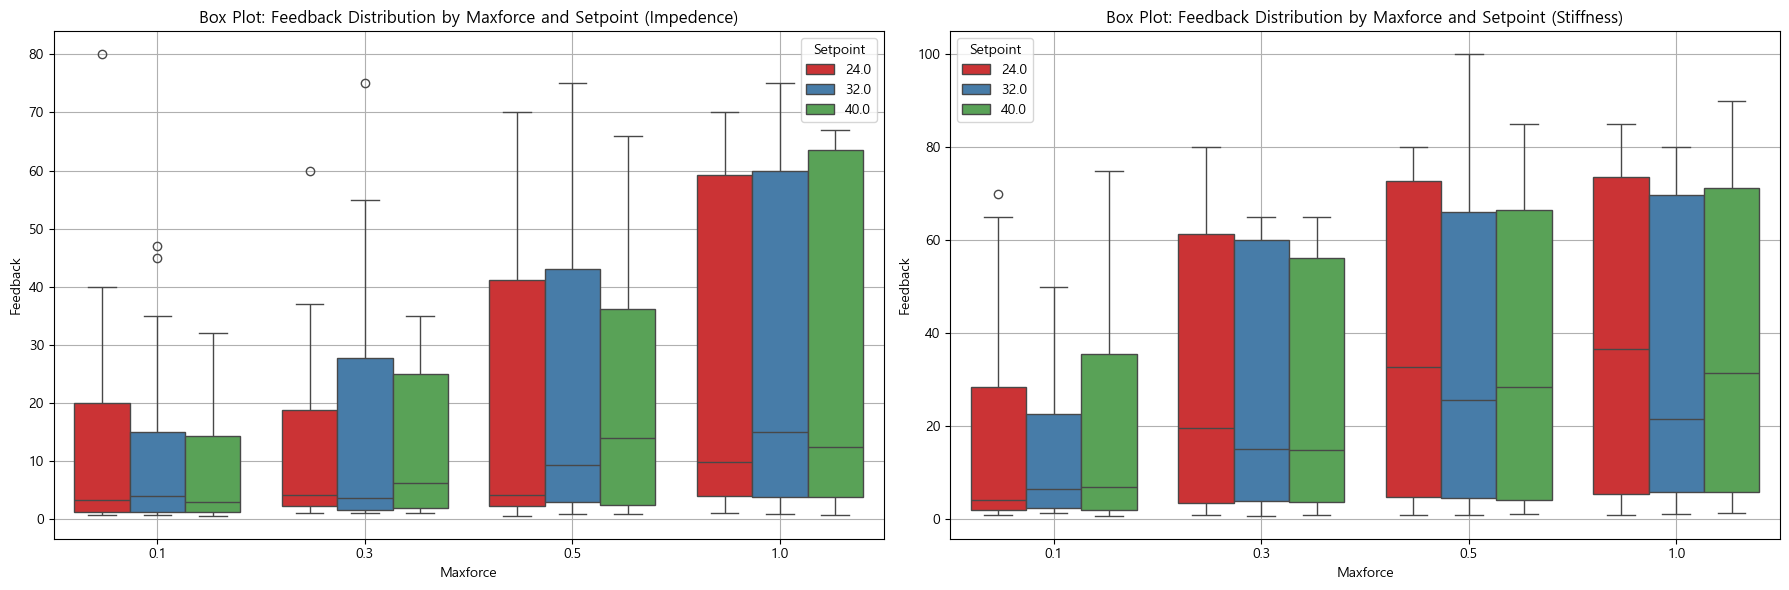

In [128]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: Impedence data
sns.boxplot(x='Maxforce', y='Feedback', hue='Setpoint', data=impedence_df, palette='Set1', ax=axes[0])
axes[0].set_title('Box Plot: Feedback Distribution by Maxforce and Setpoint (Impedence)')
axes[0].set_xlabel('Maxforce')
axes[0].set_ylabel('Feedback')
axes[0].grid(True)

# Second subplot: Stiffness data
sns.boxplot(x='Maxforce', y='Feedback', hue='Setpoint', data=stiffness_df, palette='Set1', ax=axes[1])
axes[1].set_title('Box Plot: Feedback Distribution by Maxforce and Setpoint (Stiffness)')
axes[1].set_xlabel('Maxforce')
axes[1].set_ylabel('Feedback')
axes[1].grid(True)

# Adjust layout for spacing
plt.tight_layout()
plt.show()

### **🧷 실험 경험별 데이터 분석**

In [129]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

Average Feedback for Using 0:
          Stiffness Using 0  Impedence Using 0
Maxforce                                      
0.1               35.072222          24.611111
0.3               40.333333          27.166667
0.5               45.755556          34.022222
1.0               45.422222          29.094444

Average Feedback for Using 1:
          Stiffness Using 1  Impedence Using 1
Maxforce                                      
0.1                8.403333           4.096667
0.3               21.883333           7.756667
0.5               30.913333          14.445000
1.0               34.293333          27.456667


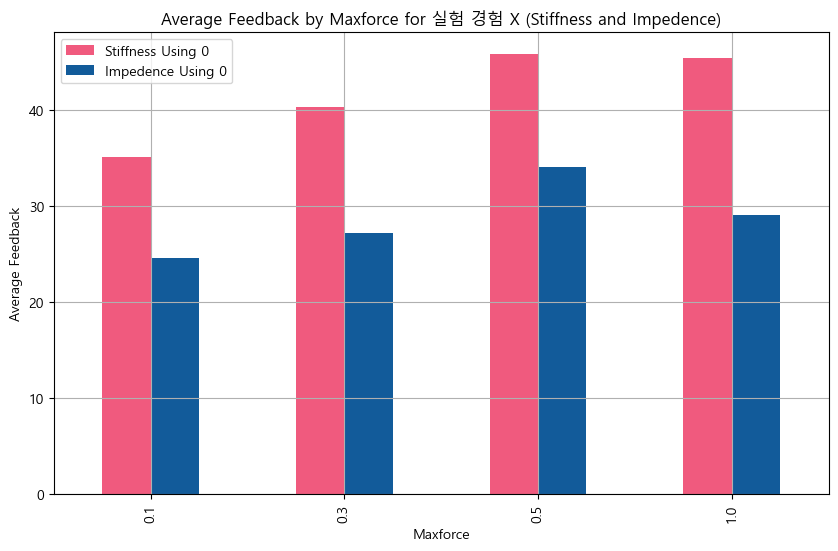

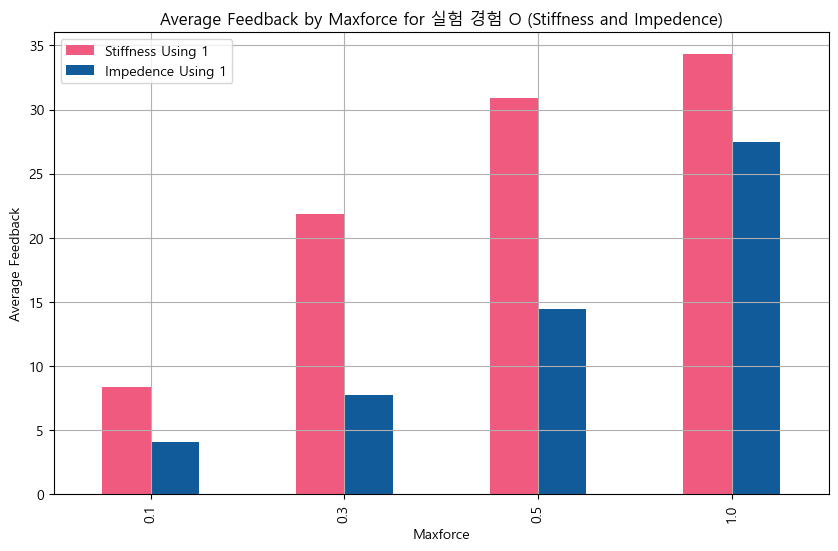

In [130]:
# Split by 'using' column
stiffness_using_0 = stiffness_df[stiffness_df['using'] == 0]
stiffness_using_1 = stiffness_df[stiffness_df['using'] == 1]

impedence_using_0 = impedence_df[impedence_df['using'] == 0]
impedence_using_1 = impedence_df[impedence_df['using'] == 1]

# Calculate average Feedback by Maxforce for each group
avg_feedback_stiffness_0 = stiffness_using_0.groupby('Maxforce')['Feedback'].mean()
avg_feedback_stiffness_1 = stiffness_using_1.groupby('Maxforce')['Feedback'].mean()

avg_feedback_impedence_0 = impedence_using_0.groupby('Maxforce')['Feedback'].mean()
avg_feedback_impedence_1 = impedence_using_1.groupby('Maxforce')['Feedback'].mean()

# Create a DataFrame for using 0
avg_feedback_using_0 = pd.DataFrame({
    'Stiffness Using 0': avg_feedback_stiffness_0,
    'Impedence Using 0': avg_feedback_impedence_0
})

# Create a DataFrame for using 1
avg_feedback_using_1 = pd.DataFrame({
    'Stiffness Using 1': avg_feedback_stiffness_1,
    'Impedence Using 1': avg_feedback_impedence_1
})

# Display both dataframes separately
print("Average Feedback for Using 0:")
print(avg_feedback_using_0)

print("\nAverage Feedback for Using 1:")
print(avg_feedback_using_1)

# Plot the data for Using 0
avg_feedback_using_0.plot(kind='bar', figsize=(10, 6), color=['#F05A7E', '#125B9A'])
plt.title('Average Feedback by Maxforce for 실험 경험 X (Stiffness and Impedence)')
plt.xlabel('Maxforce')
plt.ylabel('Average Feedback')
plt.grid(True)
plt.show()

# Plot the data for Using 1
avg_feedback_using_1.plot(kind='bar', figsize=(10, 6), color=['#F05A7E', '#125B9A'])
plt.title('Average Feedback by Maxforce for 실험 경험 O (Stiffness and Impedence)')
plt.xlabel('Maxforce')
plt.ylabel('Average Feedback')
plt.grid(True)
plt.show()

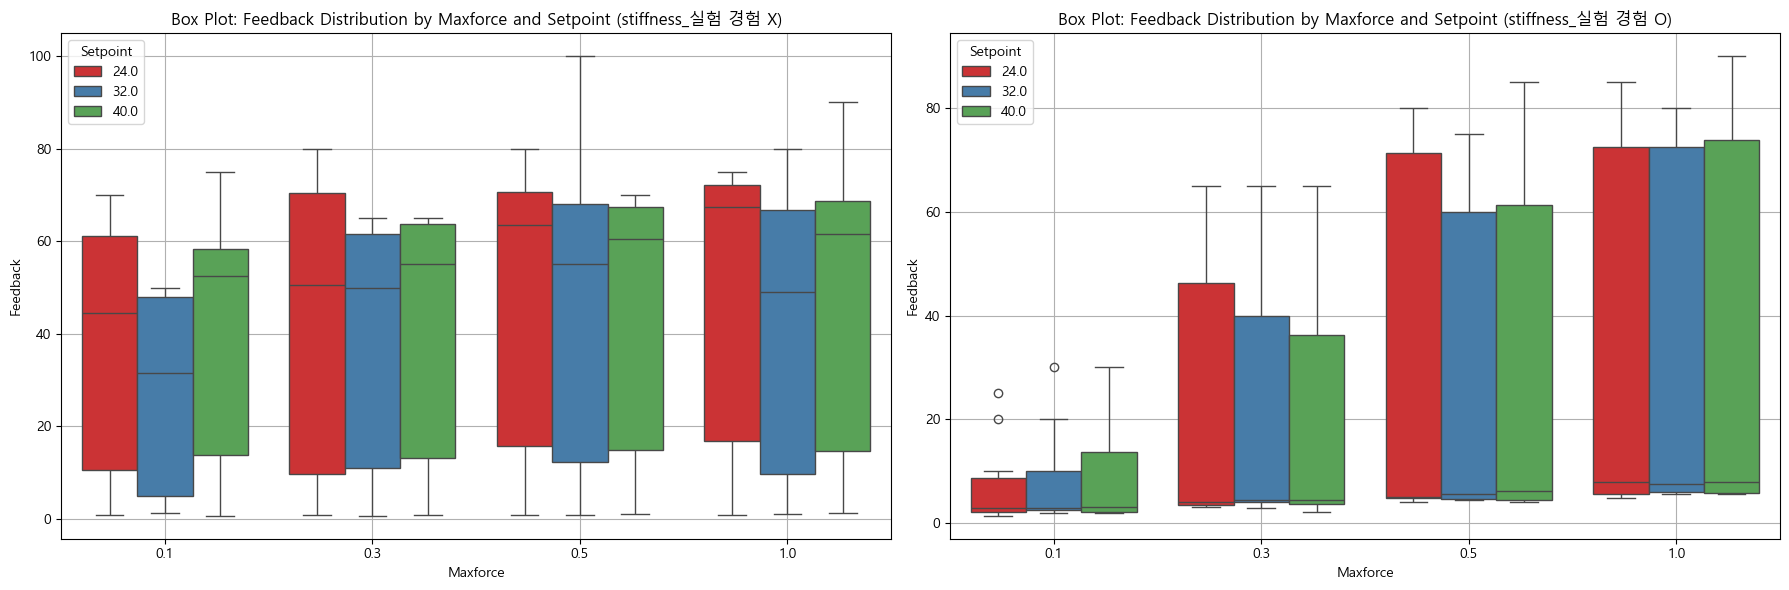

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: stiffness_using_0
sns.boxplot(x='Maxforce', y='Feedback', hue='Setpoint', data=stiffness_using_0, palette='Set1', ax=axes[0])
axes[0].set_title('Box Plot: Feedback Distribution by Maxforce and Setpoint (stiffness_실험 경험 X)')
axes[0].set_xlabel('Maxforce')
axes[0].set_ylabel('Feedback')
axes[0].grid(True)

# Second subplot: stiffness_using_1
sns.boxplot(x='Maxforce', y='Feedback', hue='Setpoint', data=stiffness_using_1, palette='Set1', ax=axes[1])
axes[1].set_title('Box Plot: Feedback Distribution by Maxforce and Setpoint (stiffness_실험 경험 O)')
axes[1].set_xlabel('Maxforce')
axes[1].set_ylabel('Feedback')
axes[1].grid(True)

# Adjust layout for spacing
plt.tight_layout()
plt.show()

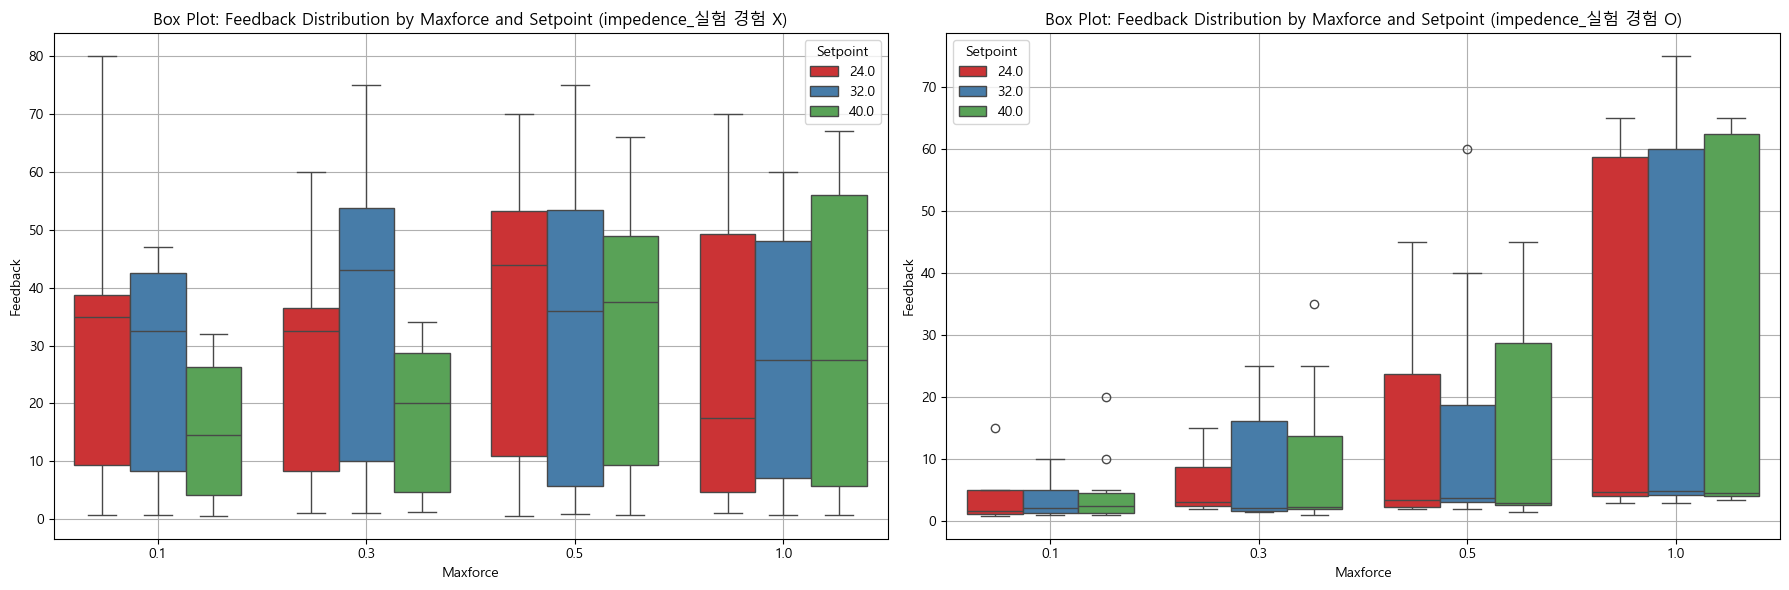

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: stiffness_using_0
sns.boxplot(x='Maxforce', y='Feedback', hue='Setpoint', data=impedence_using_0, palette='Set1', ax=axes[0])
axes[0].set_title('Box Plot: Feedback Distribution by Maxforce and Setpoint (impedence_실험 경험 X)')
axes[0].set_xlabel('Maxforce')
axes[0].set_ylabel('Feedback')
axes[0].grid(True)

# Second subplot: stiffness_using_1
sns.boxplot(x='Maxforce', y='Feedback', hue='Setpoint', data=impedence_using_1, palette='Set1', ax=axes[1])
axes[1].set_title('Box Plot: Feedback Distribution by Maxforce and Setpoint (impedence_실험 경험 O)')
axes[1].set_xlabel('Maxforce')
axes[1].set_ylabel('Feedback')
axes[1].grid(True)

# Adjust layout for spacing
plt.tight_layout()
plt.show()